# Machine Learning 1 -- A sea in the Data

What happens here is very simple. We make plots. PCA is more detailed in [ML3](ML 3 -- see in the data.ipynb), in which case more control on the data is available.

In [1]:
%matplotlib inline
import pandas as pd
from string import atoi,atof
import seaborn as sns

## Load the data
The dataframe was stored as hdf5. It contains quite some columns..

Remember that **negative values mark empty fields**.

In [9]:
dataframe=pd.read_hdf('data/CL_flats.h5','CL_flats')
print 'Available features:'
print ', '.join(dataframe.columns)
print 
dataframe.iloc[:4]

Available features:
ins date, idx, url, sqm, price, floor, loc, metro, district, date in, text in, flat, apartment, carport, furnished, duplex, no smoking, street parking, house, laundry in bldg, w/d hookups, dogs are OK - wooof, w/d in unit, no parking, townhouse, no laundry on site, laundry on site, attached garage, wheelchair accessible, condo, off-street parking, title, desc



,ins date,idx,url,sqm,price,floor,loc,metro,district,date in,...,no parking,townhouse,no laundry on site,laundry on site,attached garage,wheelchair accessible,condo,off-street parking,title,desc
0,2016-07-24 05:21,5655583144,http://paris.craigslist.fr/apa/5655583144.html,66,2080,-1,place a ce jour 13 arrondissement,Tolbiac,13,2016-06-27,...,False,False,False,False,False,False,False,False,Elegant appartement 66m2 1 chambre avec balcon...,Elegant appartement 66m2 1 chambre avec balcon...
1,2016-07-24 05:21,5655584213,http://paris.craigslist.fr/apa/5655584213.html,79,2800,-1,4 arrondissement,Cité,4,2016-06-27,...,False,False,False,False,False,False,False,False,Deux-pieces a la mode a louer dans le centre d...,Deux-pieces a la mode a louer dans le centre d...
2,2016-07-23 18:55,5693410725,http://paris.craigslist.fr/apa/5693410725.html,74,2100,9,13 arrondissement,Tolbiac,13,2016-07-31,...,False,False,False,False,False,False,False,False,RUE DE TOLBIAC APARTMENT WITH LARGE TERRACE,RUE DE TOLBIAC APARTMENT WITH LARGE TERRACE\nA...
3,2016-07-23 18:54,5693407355,http://paris.craigslist.fr/apa/5693407355.html,54,2150,2,Bd Richard Lenoir 11 arrondissement,Oberkampf,11,2016-07-23,...,False,False,False,False,False,False,False,True,Bd Richard Lenoir : well located spacious apar...,Bd Richard Lenoir : well located spacious apar...


In [10]:
# this should have been done in the 3rd step!! :/
clear_floor = lambda x: x if x<10 else -1
def clear_dist(x):
    """
        Remove districts outside Paris
    """
    try:
        return atoi(str(x))
    except Exception,m:
        #"Ca n'est pas paris!"
        return -2 #use negative number to mark negative field ;)
dataframe.floor=dataframe.floor.apply(clear_floor)
dataframe.district = dataframe.district.apply(clear_dist)

# We use some smart _pandas_

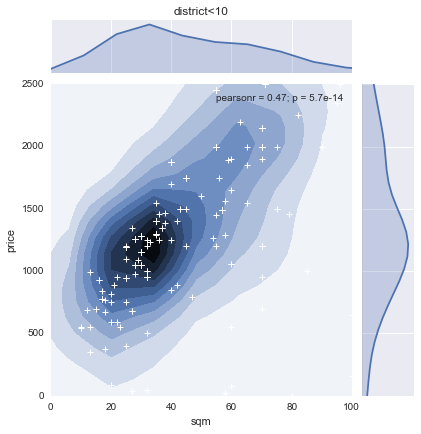

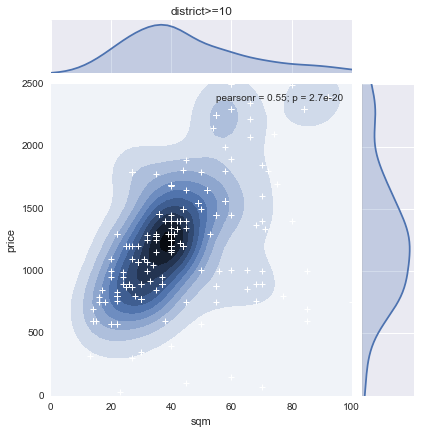

In [4]:
trhs = 10
dataframe['district_binary'] = dataframe.district.apply(lambda x:0<x<trhs)
ax=sns.jointplot(x="sqm", y="price", kind='kde',data=dataframe[dataframe.district_binary],xlim=[0,100],ylim=[0,2500])
ax.plot_joint(sns.plt.scatter, c="w", s=30, linewidth=1, marker="+")
ax.ax_marg_x.set_title("district<{0:d}".format(trhs))
dataframe['district_binary'] = dataframe.district.apply(lambda x:x>=trhs)
ax=sns.jointplot(x="sqm", y="price", kind='kde',data=dataframe[dataframe.district_binary],xlim=[0,100],ylim=[0,2500])
ax.plot_joint(sns.plt.scatter, c="w", s=30, linewidth=1, marker="+")
ax.ax_marg_x.set_title("district>={0:d}".format(trhs))

# Unsupervised ML: PCA

In [5]:
from sklearn.decomposition import PCA,KernelPCA
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import Normalizer

It turns out that it is useful to bin the size and the price to reduce noise to a human level, after all, $\text{price}_0 \pm 50$ is still $\text{price}_0$. Here we use `numpy.digitize`, with bins of 250 euros and 10 sqm for the price and the size.

In [ ]:
dataframe['price_bin']=sns.np.digitize(dataframe.price,bins=sns.np.arange(0,21*250,250))
dataframe['sqm_bin']=sns.np.digitize(dataframe.sqm,bins=sns.np.arange(0,130,10))
dataframe['price_sqm']=dataframe.price/dataframe.sqm

To have the best performance, each columns has to be _normalized_ to unit variance. With a physical mind-set, after normalization each column has the same unit: no-unit. Before normalization we were comparing apples and strawberries.

In [19]:
X = dataframe[['price_bin','district','sqm_bin','furnished','price_sqm','floor']][dataframe.district>0]
normalizer = Normalizer()
Xa = normalizer.fit_transform(sns.np.array(X).astype('float'))

### Do the PCA

In [21]:
pca = PCA(n_components=3)
pca.fit(Xa[:,:-1])
X_r = pca.transform(Xa[:,:-1])

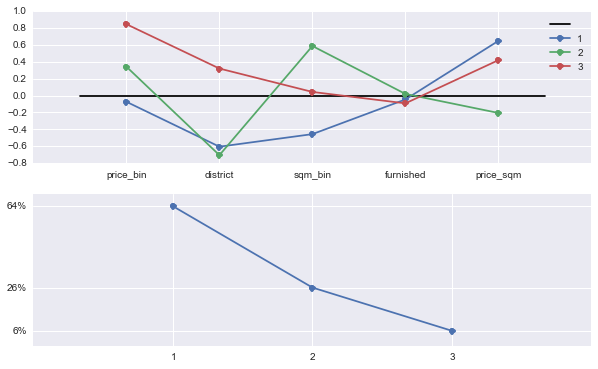

In [22]:
cols = X.columns[:-1]
ncols = len(cols)
modes = pca.explained_variance_ratio_
nmodes = len(modes)
f,(ax,bx)=sns.plt.subplots(2,1,figsize=[10,6])
ax.plot([-.5,ncols-.5],[0,0],'-k')

ax.plot(pca.components_.T,'-o')
ax.xaxis.set_ticks(range(ncols))
ax.xaxis.set_ticklabels(cols)
ax.set_xlim(-1,ncols)

bx.plot(range(1,nmodes+1),modes*100,'-o')
bx.set_xlim(0,nmodes+1)
bx.xaxis.set_ticks(range(1,nmodes+1))
bx.yaxis.set_ticks(modes*100)
bx.yaxis.set_ticklabels(['%d%%'%j for j in modes*100])
_=ax.legend(' 123')

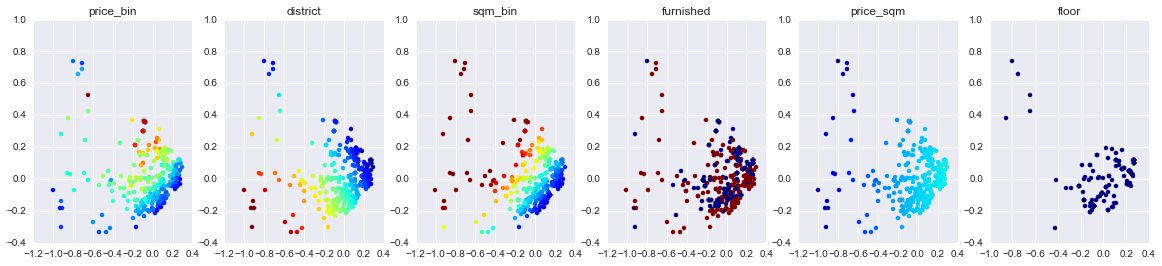

In [24]:
cols = X.columns
clrs = len(cols)

fig,axs = sns.plt.subplots(1,clrs,figsize=(20,4))

for clr in xrange(clrs):
    ax = axs[clr]
    mp = sns.np.median(Xa[:,clr])*3.
    if cols[clr]=='metro':
        mp = Xa[:,clr].max()
#     xyz=[] # for gridding

    for i,j in enumerate(X_r):
        
        df=Xa[i]
        if df[clr]>=0: #  Because <0 means no-data
            ax.scatter(j[0],j[1],c=sns.plt.cm.jet(df[clr]/mp),lw=0)
#             xyz.append((j[0],j[1],df[clr]))
#     xyz = np.array(xyz)
    
    ax.set_title(cols[clr])
    # pl.xlim(-.1,.1)
    # pl.ylim(-.07,0)

** Obserbations **
* The field furnished is essentialy disregarded by the pca 
* This is where we skip the interpretation, and leave it to the last notebook

# PCA-inspired plots with _seaborn_

In [25]:
sorted_district_by_aveprice = []
__tmp = []
for c in X.groupby('district'):
    __tmp.append((c[0],c[1].price_sqm.mean()))
import numpy as np
__tmp = np.asarray(__tmp)
__sidx = np.argsort(__tmp[:,1])
sorted_district_by_aveprice = __tmp[__sidx][:,0]
sorted_district_by_aveprice_labels = ['%d'%j for j in sorted_district_by_aveprice]

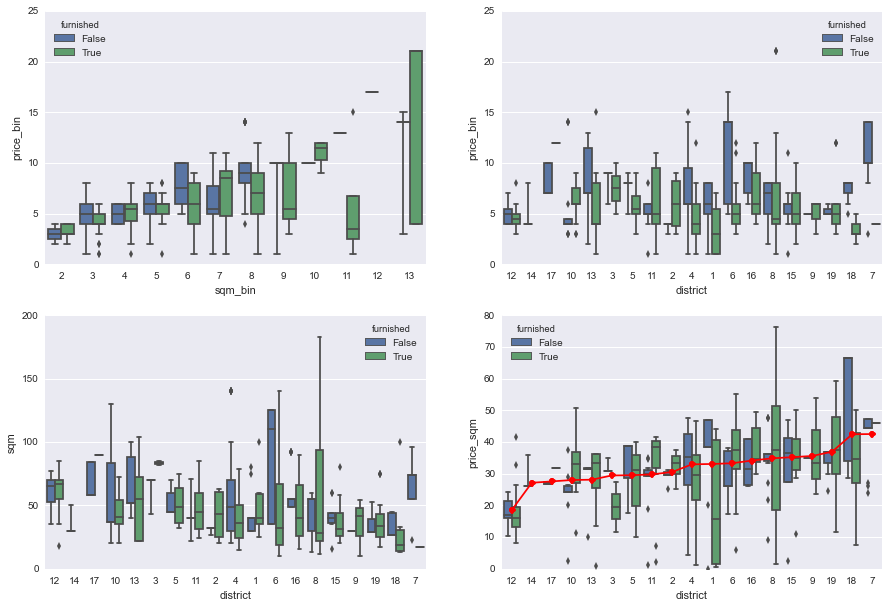

In [26]:
f ,((ax,bx),(cx,dx)) = sns.plt.subplots(2,2,figsize=(15,10))
sns.boxplot(y="price_bin", x="sqm_bin", hue = "furnished",data=X,ax=ax);
sns.boxplot(y="price_bin", x="district", hue = "furnished",data=X,ax=bx,order = sorted_district_by_aveprice)
sns.boxplot(y="sqm", x="district", hue = "furnished",data=dataframe,ax=cx,order = sorted_district_by_aveprice)
sns.boxplot(y="price_sqm", x="district", hue = "furnished",data=X,ax=dx,order = sorted_district_by_aveprice)
dx.xaxis.set_ticklabels(sorted_district_by_aveprice_labels)
cx.xaxis.set_ticklabels(sorted_district_by_aveprice_labels)
bx.xaxis.set_ticklabels(sorted_district_by_aveprice_labels)
dx.plot(__tmp[__sidx][:,1],'r-o')
cx.set_ylim(0,200);
# ax=sns.stripplot(x="price_bin", y="sqm_bin", hue="district", 
#      data=X.sort_values('district'),palette=sns.color_palette("RdBu", n_colors=21, desat=.5));
# ax.set_xlim(0,50);ax.set_ylim(0,2500)

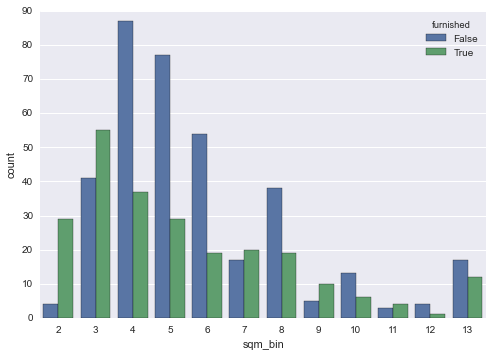

In [27]:
sns.countplot(x='sqm_bin',hue='furnished',data=dataframe)

** Observations **
* how can furnished app  be less expensive than empty apps?

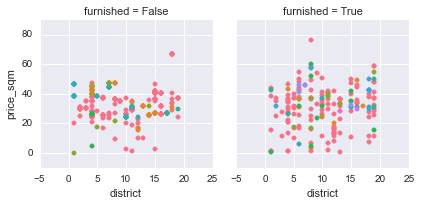

In [28]:
g = sns.FacetGrid(X, col="furnished",hue="floor", margin_titles=True)
g.map(sns.plt.scatter,"district", "price_sqm")


# Closing ..

Some final comments on this notebook:

* Some columns in dataframe are quite empty and/or not statistically relevant (eg. floor). We will try to fill them with a ML technique
* Do you know that you can save quite many things in hdf5 file, alongside to the pandas dataframe?

In [30]:
dataframe.to_hdf('data/after_ML1.h5','housesofparis')
pd.Series(sorted_district_by_aveprice).to_hdf('data/after_ML1.h5','sorted_district_by_aveprice')

In [32]:
!ls -lh after_ML1.h5

-rw-rw-r-- 1 astyonax astyonax 4,4M ago  3 10:05 after_ML1.h5


# People buy a brand, not a phone

In [11]:
from IPython.display import HTML
import urllib2

style=open('style.css','r').read()
HTML("""
<style>{0}</style>
""".format(style))